In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
print(f"{device = }")
def train_one_epoch(modelo: GIN_classifier_to_explain_v2,
                    optimizer, 
                    train_loader: torch_geometric.loader.dataloader.DataLoader,
                    loss_fun: torch.nn.modules.loss,
                    device:str='cpu' ):

    correct = 0
    for i, data in enumerate(train_loader):
        assert not data.is_cuda   
        if (device == 'cuda:0') | (device == 'cuda'):                            
            data.to(device, non_blocking=True) 
            assert data.is_cuda       
                
        optimizer.zero_grad(set_to_none=True) # Zero your gradients for every batch        
        if (device == 'cuda:0') | (device == 'cuda'):
            #with torch.cuda.amp.autocast():      
            predictions = modelo(data.x, data.edge_index,  data.batch)# Make predictions for this batch
            loss        = loss_fun(predictions, data.y)
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.        
            pred     = predictions.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(train_loader.dataset)

def validate(modelo: GIN_classifier_to_explain_v2, loader: DataLoader, device: str = 'cpu'):
    modelo.eval()
    correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda                          

        val_predictions = modelo(val_data.x, val_data.edge_index,  val_data.batch)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)

        correct += int((pred == val_data.y).sum())
        

    return correct / len(loader.dataset)   

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


In [2]:
class my_GNN(torch.nn.Module):
    
    def __init__(
        self, 
        model:str ,
        n_classes: int,
        n_nodes : int, 
        num_features : int, 
        out_channels: int = 8,
        dropout : float = 0.05, 
        hidden_dim : int = 8, 
        LeakyReLU_slope : float = 0.01,
        num_layers: int = 2,
        
        
    ):
        super(my_GNN, self).__init__() # TODO: why SUPER gato? 
        self.n_nodes = n_nodes
        self.n_classes = n_classes
        self.dropout = dropout
        self.num_features = num_features
        self.out_channels = out_channels
        self.model        = model
        
        if self.model == "GCN":    
            self.GNN_layers =  GCN(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, 
                                out_channels= out_channels, dropout=dropout,  jk=None, act='LeakyReLU', act_first = False) 
    
        elif self.model == "GAT":        
             self.GNN_layers =  GAT(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, 
                                    out_channels= out_channels, dropout=dropout,  jk=None, act='LeakyReLU', act_first = False) 

        elif self.model == "GIN":
             self.GNN_layers =  GIN(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, 
                                    out_channels= out_channels, dropout=dropout,  jk=None, act='LeakyReLU', act_first = False)
        
        #self.GIN_layers =  GIN(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, 
        #                       out_channels= out_channels, dropout=dropout,  jk=None, act='LeakyReLU', act_first = False)              
        self.FC1          = Linear(in_features=out_channels, out_features=1, bias=True)
        self.FC2          = Linear(in_features= self.n_nodes, out_features=self.n_classes, bias=True)
        #self.FC          = Linear(in_features=out_channels, out_features=1, bias=True)           
           
        self.leakyrelu  = LeakyReLU(LeakyReLU_slope)#.to('cuda')
    def forward(self, x, edge_index, batch):
        batch_size = batch.unique().__len__()

        x     = self.GNN_layers(x, edge_index)
        x     = x.reshape(batch_size, self.n_nodes, self.out_channels)
        x     = self.FC1(self.leakyrelu(x))
        x     = x.reshape(batch_size,  self.n_nodes)       
        x     = self.FC2(self.leakyrelu(x))    

        return torch.nn.functional.log_softmax(x, dim=1)

In [46]:
#loader_path     = 

#saving_subfolder = "/Non_masked_Phe"
import os

def train_and_validate(gnn_type, mask, flux, loader_path , EPOCHS, save, verbose, saving_folder, device:str="cuda"):
    
    
    if not mask and not flux:
        assert "loader_only_Concen.pt"        == os.path.basename(loader_path)
        
    elif not mask and flux:
        assert "loader_Concen_plus_Fluxes.pt" == os.path.basename(loader_path)
        
    elif mask and not flux:
        assert "MASKED_loader_only_Concen.pt" == os.path.basename(loader_path)
        
    elif mask and not flux:
        assert "MASKED_loader_Concen_plus_Fluxes.pt" == os.path.basename(loader_path)
    loader = torch.load(loader_path)

    a_batch         = next(iter(loader.get_train_loader()))
    a_graph         = a_batch[0]
    
    model           = my_GNN( model=gnn_type,
                                            n_nodes = a_graph.num_nodes, 
                                            num_features = a_graph.num_node_features, 
                                            n_classes = a_graph.num_classes,
                                            hidden_dim=8,
                                            num_layers=3).to(device, non_blocking=True).to(device)
    
    
    optimizer       = torch.optim.Adam(model.parameters())
    loss_function   = torch.nn.NLLLoss()
    gc.collect()
    torch.cuda.empty_cache() 
    model_type = model.GNN_layers.__class__.__name__


    
    all_train_accuracy_Unmasked = []
    all_validation_accuracy_Unmasked = []
    best_validation_accuracy = 1e-10
    for epoch in tqdm.tqdm(range(EPOCHS)):
        
        train_accuracy = train_one_epoch(model,
                            optimizer=optimizer, 
                            train_loader=loader.get_train_loader(),
                            loss_fun=loss_function,
                            device = device)

        validation_accuracy = validate(model, loader.get_validation_loader(), device)
        
        all_train_accuracy_Unmasked.extend([train_accuracy])
        all_validation_accuracy_Unmasked.extend([validation_accuracy])
        
        
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            del validation_accuracy
            best_val_state_dict   = copy.deepcopy(model.state_dict())
            best_val_model        = copy.deepcopy(model)
            
            if verbose:
                timestamp     = datetime.now().strftime('%d-%m-%Y_%Hh_%Mmin')              
                print(f'{model_type = } {flux = } {mask = } Epoch: {epoch:03d}, train_accuracy: {train_accuracy:.4f}, best_validation_accuracy: {best_validation_accuracy:.4f}')
                
                if save:
                    path = f"{saving_folder}Flux/" if flux else f"{saving_folder}Non_flux/"
                    path = f"{path}Masked/" if mask else f"{path}Non_masked/"+ model_type 
                               
                    model_path = path +'/Model_{}_{}_best_ValAcc_{}_epoch_{}.pt'.format(model_type,timestamp, best_validation_accuracy, epoch)
                    torch.save(best_val_model, model_path)
                    print(f"saved as {model_path}")
                    
    return best_val_model, all_train_accuracy_Unmasked, all_validation_accuracy_Unmasked
                    

              
 

In [57]:

GCN_F_F = train_and_validate(gnn_type = "GCN", mask = False, flux = False, loader_path = "./results/dataloaders/loader_only_Concen.pt" ,
                            EPOCHS = 10, save = False, verbose = True, saving_folder =  "./results/trained_models/")



GCN_F_T = train_and_validate(gnn_type = "GCN", mask = False, flux = True, loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt" ,
                            EPOCHS = 10, save = False, verbose = True, saving_folder =  "./results/trained_models/")


GCN_T_F = train_and_validate(gnn_type = "GCN", mask = True, flux = False, loader_path = "./results/dataloaders/MASKED_loader_only_Concen.pt" ,
                            EPOCHS = 10, save = False, verbose = True, saving_folder =  "./results/trained_models/")


GCN_T_T = train_and_validate(gnn_type = "GCN", mask = True, flux = True, loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt" ,
                            EPOCHS = 10, save = False, verbose = True, saving_folder =  "./results/trained_models/")


 10%|█         | 1/10 [00:09<01:22,  9.16s/it]

model_type = 'GCN' flux = False mask = False Epoch: 000, train_accuracy: 0.8725, best_validation_accuracy: 0.9878


 20%|██        | 2/10 [00:18<01:13,  9.14s/it]

model_type = 'GCN' flux = False mask = False Epoch: 001, train_accuracy: 0.9908, best_validation_accuracy: 0.9933


 30%|███       | 3/10 [00:27<01:03,  9.13s/it]

model_type = 'GCN' flux = False mask = False Epoch: 002, train_accuracy: 0.9936, best_validation_accuracy: 0.9947


 40%|████      | 4/10 [00:36<00:54,  9.13s/it]

model_type = 'GCN' flux = False mask = False Epoch: 003, train_accuracy: 0.9948, best_validation_accuracy: 0.9953


 10%|█         | 1/10 [00:09<01:21,  9.08s/it]

model_type = 'GCN' flux = True mask = False Epoch: 000, train_accuracy: 0.9678, best_validation_accuracy: 0.9933


 40%|████      | 4/10 [00:36<00:53,  8.99s/it]

model_type = 'GCN' flux = True mask = False Epoch: 003, train_accuracy: 0.9933, best_validation_accuracy: 0.9947


100%|██████████| 10/10 [01:30<00:00,  9.02s/it]

model_type = 'GCN' flux = True mask = False Epoch: 009, train_accuracy: 0.9951, best_validation_accuracy: 0.9953



 10%|█         | 1/10 [00:09<01:21,  9.04s/it]

model_type = 'GCN' flux = False mask = True Epoch: 000, train_accuracy: 0.5759, best_validation_accuracy: 0.8156


 20%|██        | 2/10 [00:18<01:11,  9.00s/it]

model_type = 'GCN' flux = False mask = True Epoch: 001, train_accuracy: 0.7994, best_validation_accuracy: 0.8378


 30%|███       | 3/10 [00:26<01:02,  8.98s/it]

model_type = 'GCN' flux = False mask = True Epoch: 002, train_accuracy: 0.8246, best_validation_accuracy: 0.8475


 40%|████      | 4/10 [00:35<00:53,  8.98s/it]

model_type = 'GCN' flux = False mask = True Epoch: 003, train_accuracy: 0.8420, best_validation_accuracy: 0.8537


 50%|█████     | 5/10 [00:44<00:44,  8.98s/it]

model_type = 'GCN' flux = False mask = True Epoch: 004, train_accuracy: 0.8501, best_validation_accuracy: 0.8673


 60%|██████    | 6/10 [00:53<00:35,  8.99s/it]

model_type = 'GCN' flux = False mask = True Epoch: 005, train_accuracy: 0.8590, best_validation_accuracy: 0.8759


 70%|███████   | 7/10 [01:03<00:27,  9.01s/it]

model_type = 'GCN' flux = False mask = True Epoch: 006, train_accuracy: 0.8655, best_validation_accuracy: 0.8870


 90%|█████████ | 9/10 [01:21<00:09,  9.02s/it]

model_type = 'GCN' flux = False mask = True Epoch: 008, train_accuracy: 0.8808, best_validation_accuracy: 0.9047


100%|██████████| 10/10 [01:30<00:00,  9.02s/it]

model_type = 'GCN' flux = False mask = True Epoch: 009, train_accuracy: 0.8890, best_validation_accuracy: 0.9075



 10%|█         | 1/10 [00:09<01:21,  9.08s/it]

model_type = 'GCN' flux = True mask = True Epoch: 000, train_accuracy: 0.5107, best_validation_accuracy: 0.4938


 20%|██        | 2/10 [00:18<01:12,  9.07s/it]

model_type = 'GCN' flux = True mask = True Epoch: 001, train_accuracy: 0.5635, best_validation_accuracy: 0.6304


 40%|████      | 4/10 [00:36<00:54,  9.06s/it]

model_type = 'GCN' flux = True mask = True Epoch: 003, train_accuracy: 0.6826, best_validation_accuracy: 0.7284


 50%|█████     | 5/10 [00:45<00:45,  9.05s/it]

model_type = 'GCN' flux = True mask = True Epoch: 004, train_accuracy: 0.7946, best_validation_accuracy: 0.8178


 60%|██████    | 6/10 [00:54<00:36,  9.06s/it]

model_type = 'GCN' flux = True mask = True Epoch: 005, train_accuracy: 0.8138, best_validation_accuracy: 0.8253


 70%|███████   | 7/10 [01:03<00:27,  9.07s/it]

model_type = 'GCN' flux = True mask = True Epoch: 006, train_accuracy: 0.8371, best_validation_accuracy: 0.8300


 80%|████████  | 8/10 [01:12<00:18,  9.06s/it]

model_type = 'GCN' flux = True mask = True Epoch: 007, train_accuracy: 0.8300, best_validation_accuracy: 0.8375


 90%|█████████ | 9/10 [01:21<00:09,  9.06s/it]

model_type = 'GCN' flux = True mask = True Epoch: 008, train_accuracy: 0.8525, best_validation_accuracy: 0.8478


100%|██████████| 10/10 [01:30<00:00,  9.06s/it]

model_type = 'GCN' flux = True mask = True Epoch: 009, train_accuracy: 0.8605, best_validation_accuracy: 0.8567


In [58]:
from sklearn.metrics import roc_curve, auc



def get_ROC_parameters(model, test_loader):

    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    for i, test_data in enumerate(test_loader):
            
        assert not test_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            test_data.to(device, non_blocking=True) 
            assert test_data.is_cuda                          

        test_predictions = model(test_data.x, test_data.edge_index,  test_data.batch)# Make predictions for this batch
        pred            = test_predictions.argmax(dim=1)
        y_batch         = test_data.y
        
        y_pred_tag = pred.squeeze().cpu().int().tolist()
        y_true     = y_batch.squeeze().cpu().int().tolist()
        fpr, tpr, _ = roc_curve(y_true, y_pred_tag)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)


    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)


    tprs_upper = np.minimum(mean_tprs + tprs.std(axis=0), 1)
    tprs_lower = mean_tprs - tprs.std(axis=0)
    
    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc

def put_ROC_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Test set ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=7.5)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')
    
    
def put_Learning_curve(all_train_accuracy, all_validation_accuracy, AX, letter):
    AX.plot(all_train_accuracy,  label = "Train set", linestyle="--")
    AX.plot(all_validation_accuracy,  label = "Validation set", linestyle="-")
    AX.legend(loc="lower right", fontsize=11)
    AX.set_ylabel('Accuracy (%)')
    AX.set_xlabel("Epochs")
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')



test_loader_MASKED_nonFlux   =  torch.load("./results/dataloaders/MASKED_loader_only_Concen.pt").get_test_loader()


test_loader_Unmasked        = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_test_loader()

test_loader_MASKED          = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_test_loader()



base_fpr_Unmasked, mean_tprs_Unmasked, tprs_lower_Unmasked, tprs_upper_Unmasked, mean_auc_Unmasked, std_auc_Unmasked = get_ROC_parameters(GCN_F_T[0], test_loader_Unmasked)
base_fpr_MASKED, mean_tprs_MASKED, tprs_lower_MASKED, tprs_upper_MASKED, mean_auc_MASKED, std_auc_MASKED = get_ROC_parameters(GCN_T_T[0], test_loader_MASKED)

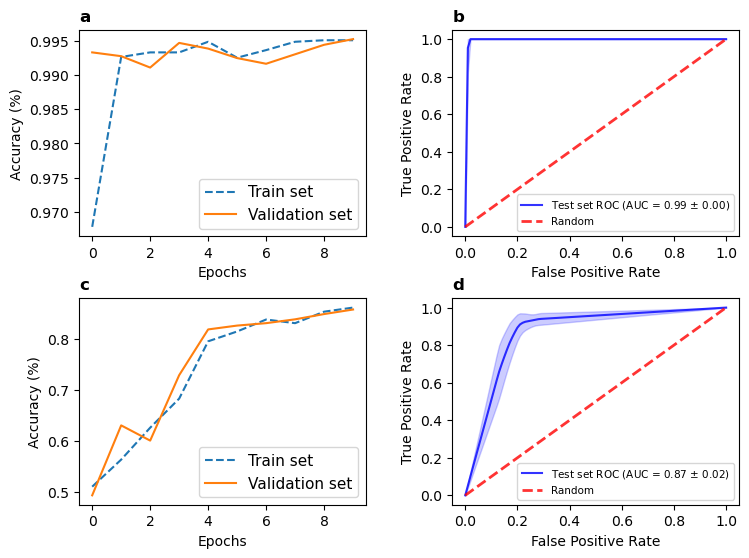

In [61]:
GCN_T_T[1]



import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11,5))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)

plt.subplots_adjust(left=0.1, bottom=0.1, right=.7, top=1.05, wspace=0.3, hspace=0.3)    


put_Learning_curve(GCN_F_T[1], GCN_F_T[2], ax0, 'a')
put_ROC_in_subplot(base_fpr_Unmasked, mean_tprs_Unmasked, tprs_lower_Unmasked, tprs_upper_Unmasked, mean_auc_Unmasked, std_auc_Unmasked,
                   ax2, xlabel = 'False Positive Rate', letter = 'b')



put_Learning_curve(GCN_T_T[1], GCN_T_T[2], ax1, 'c')
put_ROC_in_subplot(base_fpr_MASKED, mean_tprs_MASKED, tprs_lower_MASKED, tprs_upper_MASKED, mean_auc_MASKED, std_auc_MASKED,
                   ax3, xlabel = 'False Positive Rate', letter = 'd')

In [14]:
learning_curves_MASKED =  pd.DataFrame({"train_accuracy": all_train_accuracy_MASKED, "validation_accuracy": all_validation_accuracy_MASKED})
learning_curves_NON_masked = pd.DataFrame({"train_accuracy": all_train_accuracy_Unmasked, "validation_accuracy": all_validation_accuracy_Unmasked})

learning_curves_MASKED.to_csv("./results/dataframes/learning_curves_MASKED.csv")

learning_curves_NON_masked.to_csv("./results/dataframes/learning_curves_NON_masked.csv")
